In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")
DATADIR = "/home/Developer/NCSN-TF2.0/data/"

import utils
import pickle
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

tf.__version__

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

In [136]:
# %%writefile data_loader.py

import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


def load(onehot=True, ood=True):

    fname="brain_train_data.p"
    with open(fname, mode='rb') as f:
        data = pickle.load(f)


    TRAIN_TEST_RATIO=0.9
    SEED = 42

    X = data["images"]
    y = data["labels"] #.reshape(-1,1)
    
#     X_train, X_test, y_train, y_test = train_test_split(X,y,
#                                                        train_size=TRAIN_TEST_RATIO,
#                                                        stratify=y,
#                                                        random_state=SEED
#                                                        )
    X_train, y_train = [], []
    X_test, y_test = [], []
    train_classes = [0.0,1.0]#np.unique(y)
    ood_classes = [2.0, 4.0, 6.0]
    
    for i in train_classes:
        if i == 0.0:
            num=1000
        else:
            num=100
        X_train.append(X[y==i][:-num])
        y_train.append(y[y==i][:-num])
        
        X_test.append(X[y==i][-num:])
        y_test.append(y[y==i][-num:])
    
    for i in ood_classes:
        X_test.append(X[y==i])
        y_test.append(y[y==i])
    
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)
    
    if ood:
        y_train[y_train > 0] = 1
        y_test[y_test > 0] = 1
    
    
    class_weight = compute_class_weight("balanced", 
                                    classes=np.unique(y_train.flatten()),
                                    y=y_train.flatten())
    class_weight = {i:w for i,w in enumerate(class_weight)}
    print(class_weight)
    
    if onehot:
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
        enc = OneHotEncoder(sparse=False).fit(y_train)
        y_train = enc.transform(y_train)
        y_test = enc.transform(y_test)
    
    
    
    return X_train, X_test, y_train, y_test, class_weight

In [108]:
sum(y_train==1)

656

In [137]:
# %%writefile model.py

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D

def build_model(X,y):
    input_tensor = Input(shape=X.shape[1:])

    # create the base pre-trained model
    base_model = tf.keras.applications.ResNet50(
                include_top=False,
                weights=None,
                input_tensor=input_tensor,
                input_shape=None,
                pooling=None
            )

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = Dense(1024, activation='elu')(x)

    # and a logistic layer
    predictions = Dense(y.shape[-1], activation='linear')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)


    # model.summary()

    optimizer = tfk.optimizers.Adam()
    loss = tfk.losses.CategoricalCrossentropy(from_logits=True)
    metrics = [tfk.metrics.CategoricalAccuracy('accuracy', dtype=tf.float32)]
    model.compile(optimizer=optimizer, 
                loss=loss, 
                metrics=metrics)
    
    return model

In [214]:
X_train, X_test, y_train_1h, y_test_1h, class_weight = load()

{0: 0.5308357619629595, 1: 8.607469512195122}


In [215]:
X_train.shape, X_test.shape, y_train_1h.shape

((11293, 91, 109, 1), (2771, 91, 109, 1), (11293, 2))

In [216]:
# %%writefile run.py

import os, sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append("/home/Developer/NCSN-TF2.0/")
DATADIR = "/home/Developer/NCSN-TF2.0/data/"

import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# import model, data_loader
from sklearn.utils.class_weight import compute_class_weight

print(tf.__version__)

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.config.experimental.list_physical_devices('GPU')

OOD = True

X_train, X_test, y_train_1h, y_test_1h, class_weight = load()
X_train, X_test, y_train, y_test, _ = load(ood=False, onehot=False)

model = build_model(X_train, y_train_1h)

# if OOD:
#     y_train[y_train > 0] = 1
#     y_test[y_test > 0] = 1


# enc = OneHotEncoder(sparse=False).fit(y_train)
# y_train = enc.transform(y_train)
# y_test = enc.transform(y_test)

# class_weight = compute_class_weight("balanced", 
#                                     classes=np.unique(data["labels"]),
#                                     y=data["labels"])
# class_weight = {i:w for i,w in enumerate(class_weight)}
# print(class_weight)

t = int(time.time())
log_dir = 'logs/{}'.format(t)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

rows = []
ages = ['1year', '2year', '4year', '6year']
metric_types = ['fpr_tpr95','de', 'roc_auc', 'pr_auc_in','pr_auc_out','fpr_tpr80','ap']


for i in range(10):
    checkpoint_dir= os.path.join("./checkpoints", 'run_ood{}_{}'.format(int(OOD), i))
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_path = checkpoint_dir+"/{epoch:02d}.hdf5"

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
#                                                     monitor='val_accuracy',
                                                    save_best_only=False)

    model.fit(X_train, y_train_1h,
              epochs=10,
#               validation_data=(X_test[950:1050], y_test[950:1050]),
              callbacks=[cp_callback],
              class_weight=class_weight,
              shuffle=True,
              verbose=0
             )
    
    metrics = {}
    scores = -1*np.max(model.predict(X_test), axis=1)
    inlier_scores = scores[y_test==0]
    for i in np.unique(y_test):
        if i==0: continue
        y_scores = scores[y_test==i]
        name="{:d}year".format(int(i))
        metrics[name]= ood_metrics(inlier_scores, y_scores,
                                   names=("Inlier", name))
    for age in ages:
        rows.append([age] + [metrics[age][m] for m in metric_types])

df = pd.DataFrame(rows, columns=["age"]+metric_types)

2.3.1
{0: 0.5308357619629595, 1: 8.607469512195122}
{0: 0.5308357619629595, 1: 8.607469512195122}


In [213]:
X_train.shape

(11293, 91, 109, 1)

In [143]:
!ls ./checkpoints/run_ood1_12/

01.hdf5  03.hdf5  05.hdf5  07.hdf5  09.hdf5  {epoch:02d}.hdf5
02.hdf5  04.hdf5  06.hdf5  08.hdf5  10.hdf5


In [111]:
from helper import plot_confusion_matrix


Normalized confusion matrix
[[1.        0.       ]
 [0.1295578 0.8704422]]
Overall Accuracy: 0.9352


(<matplotlib.axes._subplots.AxesSubplot at 0x7f08b47c4358>,
 array([[1.       , 0.       ],
        [0.1295578, 0.8704422]]))

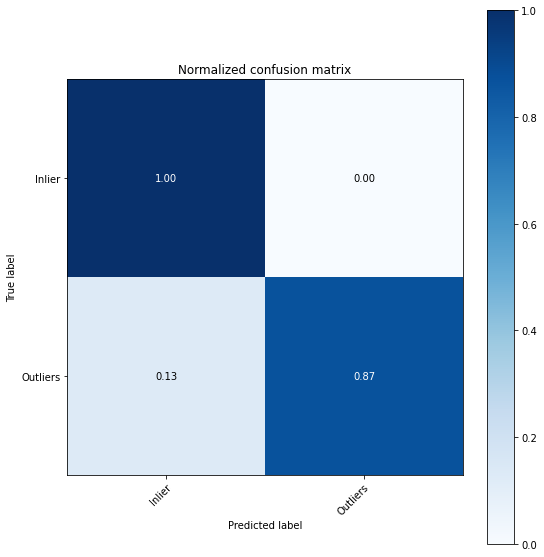

In [112]:
y_preds = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

plot_confusion_matrix(y_true, y_preds, classes=["Inlier","Outliers"], normalize=True)

In [ ]:
scores = -1*np.max(model.predict(X_test), axis=1)

In [186]:
from scipy.special import softmax
X_train, X_test, y_train, y_test, _ = load(ood=False, onehot=False)

scores = -1*np.max(model.predict(X_test), axis=1)
pd.Series(y_test).value_counts()

{0: 0.5308357619629595, 1: 8.607469512195122}


0.0    1000
2.0     582
6.0     570
4.0     519
1.0     100
dtype: int64

In [182]:
y_scores = model.predict(X_test[y_test==1])[:,-1:]
inlier_scores = model.predict(X_test[y_test==0])[:,-1:]


name="{:d}year".format(int(i))
ood_metrics(inlier_scores, y_scores,
                            names=("Inlier", name))

{'fpr_tpr95': 0.0,
 'de': 0.0,
 'roc_auc': 1.0,
 'pr_auc_in': 1.0,
 'pr_auc_out': 1.0,
 'fpr_tpr80': 0.0,
 'ap': 1.0}

In [175]:
y_scores[:4], inlier_scores[:4]

(array([[-8.754172],
        [-8.253665],
        [-7.817325],
        [-8.292737]], dtype=float32), array([[13.335422],
        [ 9.820888],
        [ 9.529435],
        [ 8.80876 ]], dtype=float32))

In [217]:
# from ood_detection_helper import ood_metrics
# import pandas as pd

# metrics = {}
# # scores = model.predict(X_test)[:,-1:]
# scores = -1*np.max(model.predict(X_test), axis=1)
# inlier_scores = scores[y_test==0]
# for i in np.unique(y_test):
#     if i==0: continue
#     y_scores = scores[y_test==i]
#     name="{:d}year".format(int(i))
#     metrics[name]= ood_metrics(inlier_scores, y_scores,
#                                names=("Inlier", name))
# rows = []
# ages = ['1year', '2year', '4year', '6year']
# metric_types = ['fpr_tpr95','de', 'roc_auc', 'pr_auc_in','pr_auc_out','fpr_tpr80','ap']

# for age in ages:
#     rows.append([age] + [metrics[age][m] for m in metric_types])

# df = pd.DataFrame(rows, columns=["age"]+metric_types)

In [222]:
df.loc[df.age=="2year"].describe() * 100

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.910000,20.111478,64.785670,70.282876,77.576297,41.220000,70.302687
std,50.182123,22.071106,43.814649,34.360082,28.084460,50.705485,34.344927
min,0.000000,0.335911,4.363918,21.357356,42.611649,0.000000,21.394636
25%,0.750000,2.272981,17.443385,34.421831,45.808094,0.075000,34.456524
50%,8.600000,6.114347,96.149656,90.442760,98.224652,5.950000,90.468047
75%,100.000000,44.040679,99.579983,99.216290,99.748966,100.000000,99.218004
max,100.000000,50.000000,99.992440,99.986920,99.995658,100.000000,99.986931


In [223]:
df.loc[df.age=="4year"].describe() * 100

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,44.960000,15.797707,79.954432,81.148586,84.799037,33.800000,81.161757
std,47.595779,15.834396,29.514087,25.426793,20.055738,43.095011,25.413387
min,0.200000,0.689017,10.005973,20.192687,46.200916,0.100000,20.237220
25%,8.350000,6.231382,72.662861,76.449748,72.242314,1.300000,76.462720
50%,14.850000,8.427890,97.189884,94.156158,98.628162,3.550000,94.166229
75%,100.000000,20.661416,98.099181,96.135791,99.041246,67.175000,96.142333
max,100.000000,50.000000,99.927553,99.854727,99.964182,100.000000,99.854875


In [224]:
df.loc[df.age=="6year"].describe() * 100

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,44.900000,18.654649,81.454439,80.671654,86.604019,29.680000,80.686248
std,36.086686,13.769146,27.050939,22.642270,17.817914,33.191257,22.631666
min,4.000000,4.292982,9.501579,21.622857,43.829201,0.400000,21.663873
25%,16.425000,8.824781,80.371228,79.908736,83.058529,5.550000,79.921064
50%,31.500000,15.026754,93.161842,89.182180,95.968509,11.500000,89.194168
75%,68.700000,21.899123,96.464035,92.937065,98.167649,50.700000,92.949102
max,100.000000,50.000000,99.008947,98.563557,99.372708,99.800000,98.564722


In [178]:
print(metrics.T.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  fpr\_tpr95 &         de &    roc\_auc &  pr\_auc\_in &  pr\_auc\_out &  fpr\_tpr80 &         ap \\
\midrule
1year &       17.3 &  10.250000 &  89.899000 &  31.035283 &   98.992959 &       14.5 &  31.480106 \\
2year &       10.2 &   7.469588 &  97.034708 &  93.519029 &   98.538575 &        4.7 &  93.528565 \\
4year &        2.1 &   2.692678 &  99.563006 &  99.036234 &   99.794819 &        0.5 &  99.037382 \\
6year &        2.0 &   2.452632 &  99.446491 &  98.774703 &   99.727221 &        0.8 &  98.776320 \\
\bottomrule
\end{tabular}



In [178]:
print(metrics.T.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  fpr\_tpr95 &         de &    roc\_auc &  pr\_auc\_in &  pr\_auc\_out &  fpr\_tpr80 &         ap \\
\midrule
1year &       17.3 &  10.250000 &  89.899000 &  31.035283 &   98.992959 &       14.5 &  31.480106 \\
2year &       10.2 &   7.469588 &  97.034708 &  93.519029 &   98.538575 &        4.7 &  93.528565 \\
4year &        2.1 &   2.692678 &  99.563006 &  99.036234 &   99.794819 &        0.5 &  99.037382 \\
6year &        2.0 &   2.452632 &  99.446491 &  98.774703 &   99.727221 &        0.8 &  98.776320 \\
\bottomrule
\end{tabular}



In [144]:
print(metrics.T.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  fpr\_tpr95 &    de &    roc\_auc &  pr\_auc\_in &  pr\_auc\_out &  fpr\_tpr80 &         ap \\
\midrule
1year &       81.8 &  42.6 &  23.370000 &   5.895751 &   87.792695 &       79.8 &   5.953859 \\
2year &       99.6 &  50.0 &  16.913230 &  23.836657 &   48.373317 &       87.5 &  23.873148 \\
4year &      100.0 &  50.0 &   7.438536 &  20.138206 &   45.384303 &       99.9 &  20.174115 \\
6year &      100.0 &  50.0 &   3.663158 &  21.123650 &   42.583323 &      100.0 &  21.157054 \\
\bottomrule
\end{tabular}



Normalized confusion matrix
[[9.97422680e-01 0.00000000e+00 8.59106529e-04 0.00000000e+00
  1.71821306e-03]
 [0.00000000e+00 9.86842105e-01 1.31578947e-02 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.31034483e-01 1.72413793e-02
  5.17241379e-02]
 [0.00000000e+00 0.00000000e+00 1.34615385e-01 1.92307692e-02
  8.46153846e-01]
 [0.00000000e+00 0.00000000e+00 3.50877193e-02 0.00000000e+00
  9.64912281e-01]]
Overall Accuracy: 0.7799


(<matplotlib.axes._subplots.AxesSubplot at 0x7f5d3070ccf8>,
 array([[9.97422680e-01, 0.00000000e+00, 8.59106529e-04, 0.00000000e+00,
         1.71821306e-03],
        [0.00000000e+00, 9.86842105e-01, 1.31578947e-02, 0.00000000e+00,
         0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.31034483e-01, 1.72413793e-02,
         5.17241379e-02],
        [0.00000000e+00, 0.00000000e+00, 1.34615385e-01, 1.92307692e-02,
         8.46153846e-01],
        [0.00000000e+00, 0.00000000e+00, 3.50877193e-02, 0.00000000e+00,
         9.64912281e-01]]))

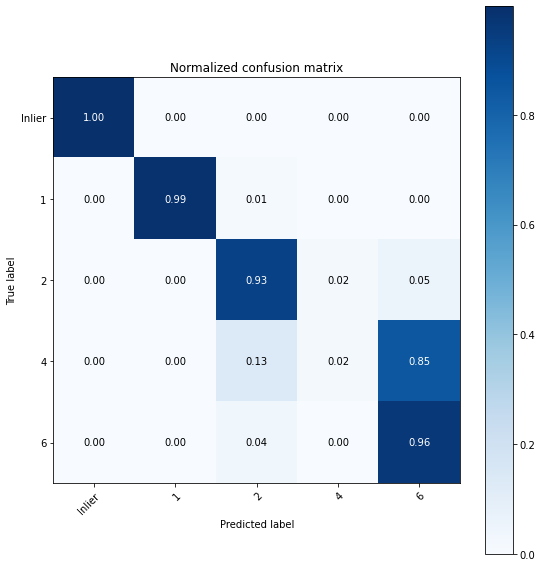

In [30]:
from helper import plot_confusion_matrix, split_valid
plot_confusion_matrix(y_true, y_preds, classes=["Inlier","1", "2", "4", "6"], normalize=True)

## TODO: train a 1 v Rest model
### Make a run file plssss